In [8]:
# Imports libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme()

# Use a local processed folder inside the Colab runtime
PROCESSED_DIR = '/content/Customer_Churn_Project/data/processed'
RAW_LOCAL_PATH = '/content/Customer_Churn_Project/data/raw'
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(RAW_LOCAL_PATH, exist_ok=True)

print("Local processed path expected:", PROCESSED_DIR)
print("Local raw path (optional):", RAW_LOCAL_PATH)

Local processed path expected: /content/Customer_Churn_Project/data/processed
Local raw path (optional): /content/Customer_Churn_Project/data/raw


In [12]:
# Load dataset directly from Drive
import pandas as pd

file_id = "102QKx509RtznVaGoH3eel8PWlB1NsViA"

# direct-download link
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Try direct read first
try:
    df = pd.read_csv(url)
    print("Loaded dataset shape (direct):", df.shape)
except Exception as e:
    print("Direct read failed:", e)
    # fallback to gdown with fuzzy=True if got error
    !pip install -q gdown
    import gdown

    out = "/content/Customer_Churn_Project/data/raw/Telco-Customer-Churn.csv"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", out, quiet=False, fuzzy=True)

    # Now load the downloaded CSV
    df = pd.read_csv(out)
    print("Loaded dataset shape (via gdown):", df.shape)

# show sample
df.head(5)

Loaded dataset shape (direct): (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
# Basic schema & data types & unique counts
print("Columns and dtypes:")
display(df.dtypes)

print("\nSample unique counts for categorical-ish columns (first 12):")
for col in df.columns[:12]:
    print(f"{col}: unique={df[col].nunique()}")

Columns and dtypes:


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object



Sample unique counts for categorical-ish columns (first 12):
customerID: unique=7043
gender: unique=2
SeniorCitizen: unique=2
Partner: unique=2
Dependents: unique=2
tenure: unique=73
PhoneService: unique=2
MultipleLines: unique=3
InternetService: unique=3
OnlineSecurity: unique=3
OnlineBackup: unique=3
DeviceProtection: unique=3


In [14]:
# Duplicates and unique key check
if 'customerID' in df.columns:
    dup_count = df.duplicated(subset=['customerID']).sum()
    print("Duplicate customerID rows:", dup_count)
else:
    print("No customerID column found — check dataset schema.")

# general duplicates
print("Total duplicate rows (all columns):", df.duplicated().sum())

Duplicate customerID rows: 0
Total duplicate rows (all columns): 0


In [15]:
# Missingness report
missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
missing_count = df.isnull().sum().sort_values(ascending=False)
dq = pd.DataFrame({'missing_count': missing_count, 'missing_pct': missing_pct})
dq = dq[dq['missing_count'] > 0].sort_values('missing_pct', ascending=False)
print("Columns with missing values (if any):")
display(dq)

# Save full column-level DQ report
full_dq = pd.DataFrame({
    'col': df.columns,
    'dtype': [str(df[c].dtype) for c in df.columns],
    'n_unique': [df[c].nunique(dropna=False) for c in df.columns],
    'missing_count': [df[c].isnull().sum() for c in df.columns],
    'missing_pct': [df[c].isnull().mean() * 100 for c in df.columns]
})
full_dq.to_csv(os.path.join(PROCESSED_DIR, 'data_quality_report_columns.csv'), index=False)
print("Saved data quality report at:", os.path.join(PROCESSED_DIR, 'data_quality_report_columns.csv'))

Columns with missing values (if any):


,missing_count,missing_pct


Saved data quality report at: /content/Customer_Churn_Project/data/processed/data_quality_report_columns.csv


In [16]:
# Convert TotalCharges if object
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == object:
    # coerce errors to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("Converted TotalCharges to numeric. Nulls introduced:", df['TotalCharges'].isnull().sum())

Converted TotalCharges to numeric. Nulls introduced: 11


In [17]:
# Basic statistics (numerical and categorical samples)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", num_cols)
display(df[num_cols].describe().T)

print("\nCategorical example value counts (up to 6 columns):")
for c in cat_cols[:6]:
    print(f"\n--- {c} ---")
    display(df[c].value_counts(dropna=False).head(10))

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80



Categorical example value counts (up to 6 columns):

--- customerID ---


,count
customerID,
3186-AJIEK,1
7590-VHVEG,1
5575-GNVDE,1
8775-CEBBJ,1
2823-LKABH,1
7398-LXGYX,1
1035-IPQPU,1
7203-OYKCT,1
1699-HPSBG,1



--- gender ---


,count
gender,
Male,3555
Female,3488



--- Partner ---


,count
Partner,
No,3641
Yes,3402



--- Dependents ---


,count
Dependents,
No,4933
Yes,2110



--- PhoneService ---


,count
PhoneService,
Yes,6361
No,682



--- MultipleLines ---


,count
MultipleLines,
No,3390
Yes,2971
No phone service,682


Churn counts:
 {'No': 5174, 'Yes': 1869}

Churn %:
 {'No': 73.4630129206304, 'Yes': 26.536987079369588}


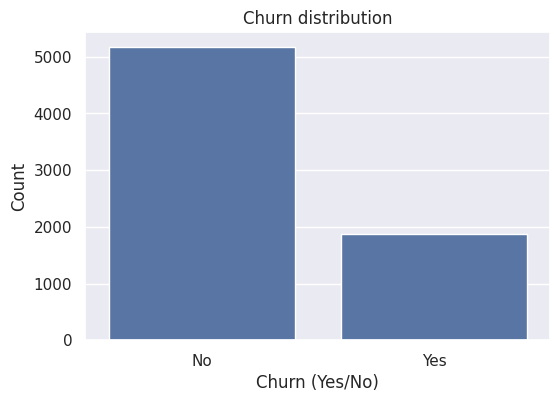

In [18]:
# Target distribution (Churn)
if 'Churn' in df.columns:
    churn_counts = df['Churn'].value_counts(dropna=False)
    churn_pct = df['Churn'].value_counts(normalize=True, dropna=False) * 100
    print("Churn counts:\n", churn_counts.to_dict())
    print("\nChurn %:\n", churn_pct.to_dict())

    # Simple barplot
    plt.figure(figsize=(6,4))
    sns.countplot(x='Churn', data=df, order=churn_counts.index)
    plt.title('Churn distribution')
    plt.xlabel('Churn (Yes/No)')
    plt.ylabel('Count')
    plt.show()
else:
    print("No Churn column found. Confirm dataset label name.")

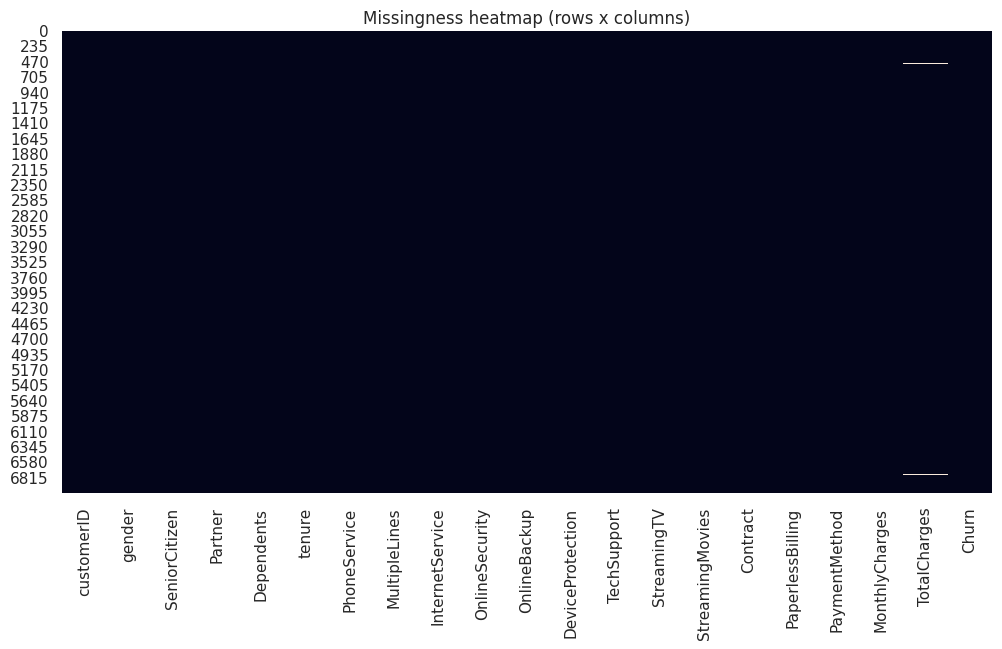

In [19]:
# Missingness heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missingness heatmap (rows x columns)')
plt.show()

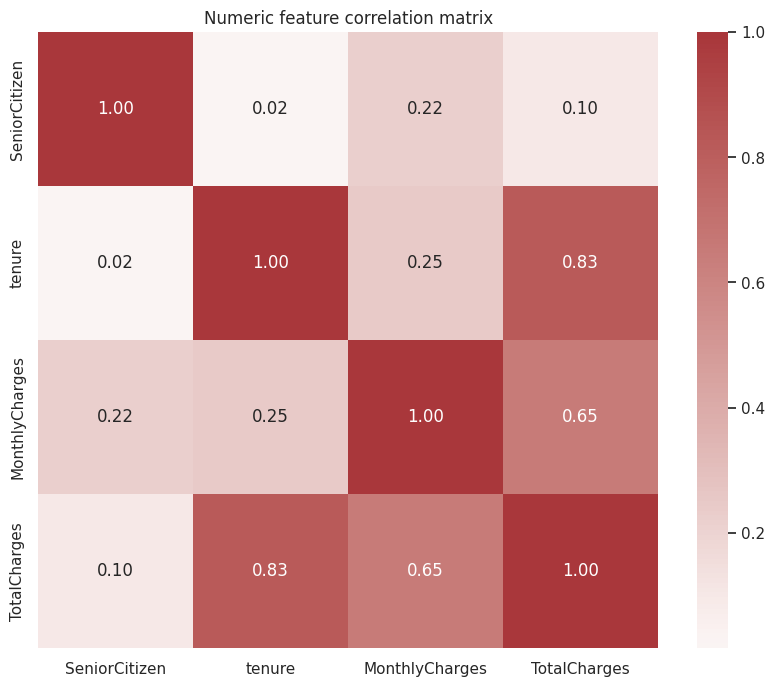

In [20]:
# Correlation check for numeric features
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title('Numeric feature correlation matrix')
    plt.show()
else:
    print("Not enough numeric columns for correlation.")

In [21]:
# Save a cleaned copy of report
df.to_csv(os.path.join(PROCESSED_DIR, 'telco_raw_loaded_converted.csv'), index=False)
print("Saved loaded dataset copy to:", os.path.join(PROCESSED_DIR, 'telco_raw_loaded_converted.csv'))

Saved loaded dataset copy to: /content/Customer_Churn_Project/data/processed/telco_raw_loaded_converted.csv


In [22]:
# Create & save a small Data Quality summary
dq_summary = {
    'n_rows': df.shape[0],
    'n_columns': df.shape[1],
    'n_duplicates': int(df.duplicated().sum()),
    'n_missing_columns': int((df.isnull().sum() > 0).sum()),
    'churn_yes_count': int(df['Churn'].value_counts().get('Yes', 0)),
    'churn_no_count': int(df['Churn'].value_counts().get('No', 0)),
    'churn_percent_yes': float((df['Churn']=='Yes').mean() * 100)
}
dq_summary_df = pd.DataFrame([dq_summary])
dq_summary_df.to_csv(os.path.join(PROCESSED_DIR, 'data_quality_summary.csv'), index=False)
print("Saved data quality summary:", os.path.join(PROCESSED_DIR, 'data_quality_summary.csv'))
dq_summary_df

Saved data quality summary: /content/Customer_Churn_Project/data/processed/data_quality_summary.csv


,n_rows,n_columns,n_duplicates,n_missing_columns,churn_yes_count,churn_no_count,churn_percent_yes
0,7043,21,0,1,1869,5174,26.536987
